# Построение baseline модели прогнозирования цен на акции

## Оглавление

1. **Импорт необходимых библиотек**
2. **Вспомогательные классы и функции**
    - `RandomTimeSplit` - класс для создания кросс-валидационных выборок данных
    - `ArimaEstimator` - класс для подбора оптимальных параметров SARIMA
    - и пр.
3. **Подготовка данных**
4. **Baseline модель**
    - `SARIMA` модель

## 1. Импорт необходимых библиотек

In [1]:
import warnings
from typing import Literal, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima
import pmdarima.warnings
from arch.unitroot import VarianceRatio
from pandas import IndexSlice as idx
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import BaseCrossValidator, cross_val_score
from sklearn.utils.validation import check_array, check_is_fitted, check_random_state
from statsmodels.tsa.stattools import InterpolationWarning, adfuller, kpss

## 2. Вспомогательные классы и функции

- `RandomTimeSplit` - класс создания Folds для кросс-валидации.  
    Выбирает `n_splits` случайных участков длины `train_size` + `test_size`

In [2]:
class RandomTimeSplit(BaseCrossValidator):
    def __init__(self, train_window, test_window, n_samples, random_state=None):
        self.train_window = train_window
        self.test_window = test_window
        self.n_splits = n_samples
        self.random_state = random_state

    def split(self, X, y=None, groups=None):
        n_samples = len(X)

        rng: np.random.RandomState = check_random_state(self.random_state)

        if n_samples < self.train_window + self.test_window:
            raise ValueError("Data size is smaller than the sum of train and test windows.")

        start_indices = rng.randint(0, n_samples - self.train_window - self.test_window, size=self.n_splits)

        for start_idx in start_indices:
            train_start = start_idx
            train_end = start_idx + self.train_window
            test_start = train_end
            test_end = test_start + self.test_window

            train_index = np.arange(train_start, train_end)
            test_index = np.arange(test_start, test_end)

            yield train_index, test_index

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

- `ArimaEstimator` - класс для поиска наиболее подходящей модели SARIMA  
    Под капотом использует пошаговый поиск оптимальных параметров: `pmdarima.auto_arima`

In [3]:
class ArimaEstimator(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        start_p: int,
        max_p: int,
        d: int,
        max_d: int,
        start_q: int,
        max_q: int,
        start_P: int,
        max_P: int,
        D: int,
        max_D: int,
        start_Q: int,
        max_Q: int,
        m: int,
        IC: Optional[Literal["aic", "aicc", "bic", "hqic", "oob"]] = "aic",
        trace: Union[bool, Literal["best"]] = False,
    ):
        self.start_p = start_p
        self.max_p = max_p
        self.d = d
        self.max_d = max_d
        self.start_q = start_q
        self.max_q = max_q
        self.start_P = start_P
        self.max_P = max_P
        self.D = D
        self.max_D = max_D
        self.start_Q = start_Q
        self.max_Q = max_Q
        self.m = m
        self.IC = IC
        if trace == "best":
            self.trace = False
            self._best = True
        else:
            self._best = False
            self.trace = trace

        self.model_: pmdarima.ARIMA = None

    def fit(self, X, y=None):
        if y is None:
            y = X
        else:
            X = check_array(X, ensure_2d=False)
            y = check_array(y, ensure_2d=False)

        self.model_ = pmdarima.auto_arima(
            y,
            start_p=self.start_p,
            max_p=self.max_p,
            d=self.d,
            max_d=self.max_d,
            start_q=self.start_q,
            max_q=self.max_q,
            start_P=self.start_P,
            max_P=self.max_P,
            D=self.D,
            max_D=self.max_D,
            start_Q=self.start_Q,
            max_Q=self.max_Q,
            m=self.m,
            trace=self.trace,
        )

        if self._best:
            print(
                f"Best model: {self.model_.order} - {self.model_.seasonal_order}; "
                f"AIC: {getattr(self.model_, self.IC)():.2f}"
            )

        return self

    def predict(self, X=None, n_periods=None):
        check_is_fitted(self)
        if (X is None) and (n_periods is None):
            raise ValueError("Either X or n_periods must be given to predict function")
        if n_periods is None:
            n_periods = len(X)
        return self.model_.predict(n_periods=n_periods)

    def score(self, X, y=None, scoring=None, n_periods=None):
        check_is_fitted(self)
        if y is None:
            y = X
        predictions = self.predict(X, n_periods=n_periods)

        if scoring is None:
            raise ValueError("No scoring metric provided.")

        if scoring == "neg_mean_absolute_error":
            return -mean_absolute_error(y, predictions)
        elif scoring == "neg_mean_squared_error":
            return -mean_squared_error(y, predictions)
        else:
            raise ValueError(f"Unsupported scoring method: {scoring}")

## 3. Подготовка данных

In [4]:
df = pd.read_csv(r".\data\df_tickers.csv", header=[0, 1], index_col=0).sort_index(axis=1)
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")

ts_df: pd.DataFrame = df.loc[:, idx[:, "close"]].dropna().droplevel(level=1, axis=1)
ts_df.head()

Ticker,LKOH,ROSN,SIBN,SNGS,TATN
date,,,,,
2006-07-19,2266.55,203.95,118.50,39.598,119.60
2006-07-20,2265.00,203.26,121.50,39.300,123.19
2006-07-21,2231.20,202.00,118.85,39.148,124.51
2006-07-24,2260.00,201.99,120.00,39.500,126.90
2006-07-25,2240.00,202.69,119.10,39.300,131.65


In [5]:
warnings.filterwarnings("ignore", category=InterpolationWarning)

ts_df_d1 = ts_df.diff().dropna()
alpha = 0.05

cv_0 = RandomTimeSplit(train_window=60, test_window=10, n_samples=100, random_state=42).split(ts_df_d1)

In [560]:
# temp_df = ts_df_d1.iloc[np.concatenate((next(cv_0)))]
temp_df = ts_df_d1

print("First differences: [ADF, PP, KPSS, VAR]")
for column in temp_df.columns:
    adf_res = "YES" if adfuller(temp_df[column])[1] <= alpha else "NO"
    pp_res = "YES" if adfuller(temp_df[column], regression="ct", autolag="AIC")[1] <= alpha else "NO"
    kpss_res = "YES" if kpss(temp_df[column])[1] > alpha else "NO"
    var_res = "YES" if VarianceRatio(temp_df[column]).pvalue > alpha else "NO"

    print(f"{column} is stationary: [ {adf_res:3} | {pp_res:3} | {kpss_res:3} | {var_res:3}]")

First differences: [ADF, PP, KPSS, VAR]
LKOH is stationary: [ YES | YES | YES | NO ]
ROSN is stationary: [ YES | YES | YES | NO ]
SIBN is stationary: [ YES | YES | YES | NO ]
SNGS is stationary: [ YES | YES | YES | NO ]
TATN is stationary: [ YES | YES | YES | NO ]


Взятия первых разностей хватает для приведения ряда к стационарному виду, согласно тестам `ADF`, `PP`, `KPSS`  
Тест на стационарность дисперсии `VAR`, закономерно, выявил, что со временем она изменяется

Если же анализировать некоторые части временного ряда длины $70$ (почему такие - описано ниже), то ситуация в целом аналогичная.

## 4. Baseline модель

В качестве базовой модели была выбрана `SARIMA`. Как правило, цель прогнозирования стоимости акций носит краткосрочный характер.  
Мы сочли нецелесообразным подгонку модели под весь временной ряд каждого из тикеров по ряду причин:
- С течением времени закономерности могли меняться, а `SARIMA` предполагает постоянные во времени коэффициенты
- В различные промежутки времени были резкие взлеты и падения, и если передать такие данные в модель,  
    то самыми оптимальными коэффициентами окажутся нули, и модель будет давать константный прогноз.

\* Данное ограничение, вероятно, будет пересмотрено, когда для моделирования будут применяться экзогенные переменные

Поэтому был выбран следующий принцип работы базовой модели:
- На вход подаются последние $60$ имеющихся значений (более 2 месяцев данных)
- На этих данных обучается наиболее оптимальная модель `SARIMA`
    - В основе сравнения качества модели лежит критерий `AIC`
- Полученная модель используется для построения прогноза на $10$ значений вперед (около полутора недель)

Указанный алгоритм был обернут в кросс-валидацию `cross_val_score`
- Из ряда выбирается `n` ($100$) случайных промежутков длиной $70$
- Для каждого участка рассчитывается MAE на тестовой выборке

In [6]:
n_samples = 100
train_window = 60
test_window = 10

cv = RandomTimeSplit(train_window=train_window, test_window=test_window, n_samples=n_samples, random_state=42)

arima_estimator = ArimaEstimator(
    start_p=0,
    max_p=5,
    d=1,
    max_d=2,
    start_q=0,
    max_q=5,
    start_P=0,
    max_P=3,
    D=1,
    max_D=1,
    start_Q=0,
    max_Q=3,
    m=7,
    trace=False,
)

__________LKOH__________
MAE on 100 samples (60/10): 128.39
STD of MAE: 118.53


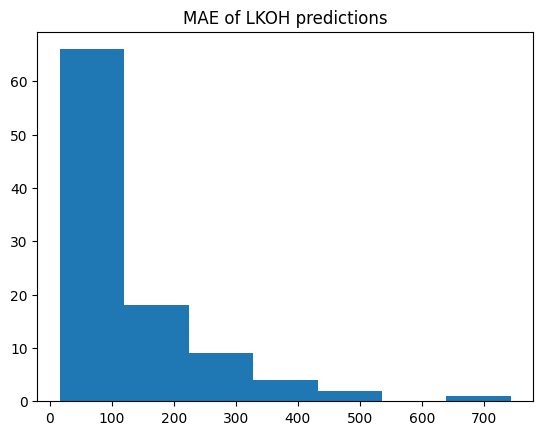

__________ROSN__________
MAE on 100 samples (60/10): 13.19
STD of MAE: 12.91


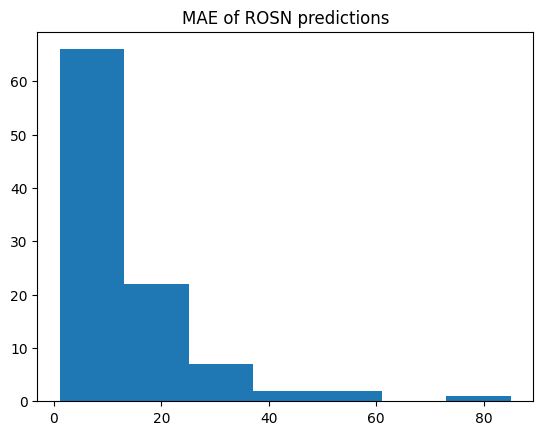

__________SIBN__________
MAE on 100 samples (60/10): 9.94
STD of MAE: 12.08


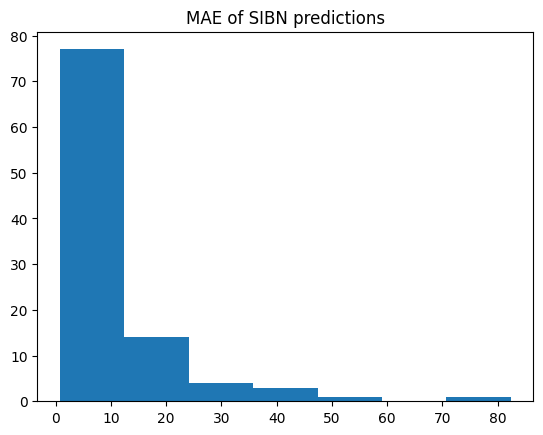

__________SNGS__________
MAE on 100 samples (60/10): 1.24
STD of MAE: 1.11


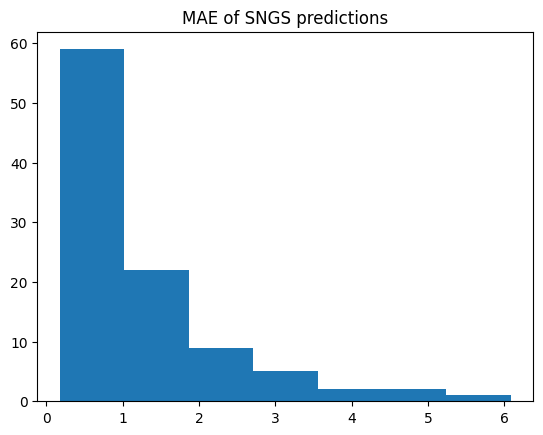

__________TATN__________
MAE on 100 samples (60/10): 14.47
STD of MAE: 13.22


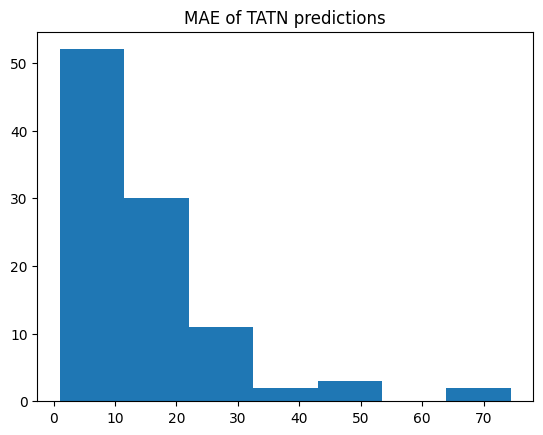

In [5]:
warnings.filterwarnings("ignore", category=pmdarima.warnings.ModelFitWarning)


def crossval():
    for col in ts_df:
        X = ts_df[[col]]

        scores = cross_val_score(arima_estimator, X, y=X, cv=cv, scoring="neg_mean_absolute_error")

        print(f"__________{col}__________")
        print(f"MAE on {n_samples} samples ({train_window}/{test_window}): {scores.mean()*(-1):.2f}")
        print(f"STD of MAE: {scores.std():.2f}")

        plt.figure(figsize=(10, 4))
        plt.hist(scores * (-1), density=False, bins=1 + int(np.floor(np.log2(len(scores)))))  # Sturges's rule
        plt.title(f"MAE of {col} predictions")
        plt.show()


# takes quite a long time

# crossval()

### Прогноз модели на последних известных значениях

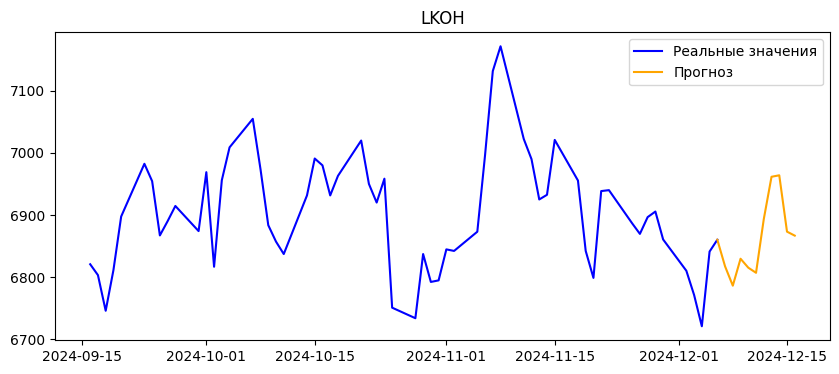

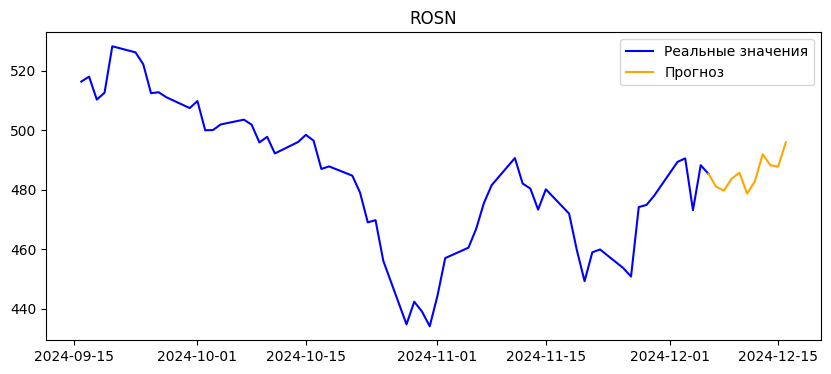

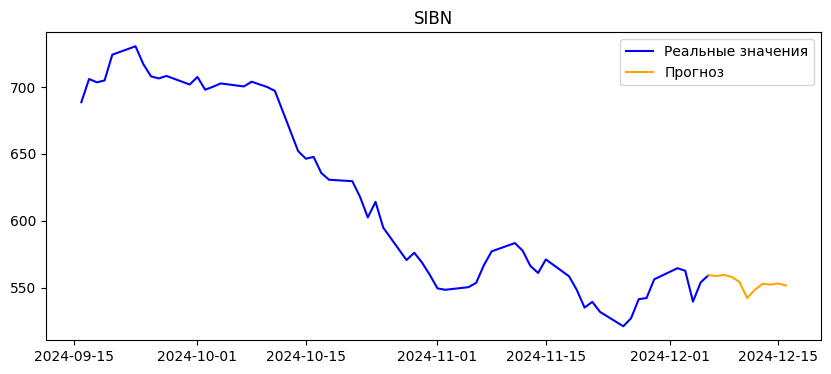

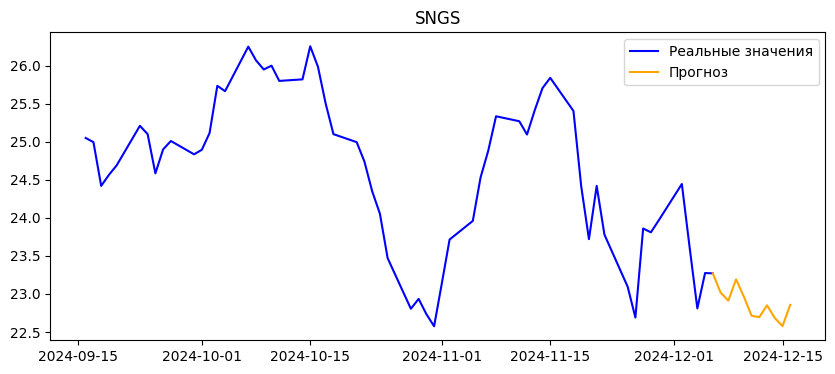

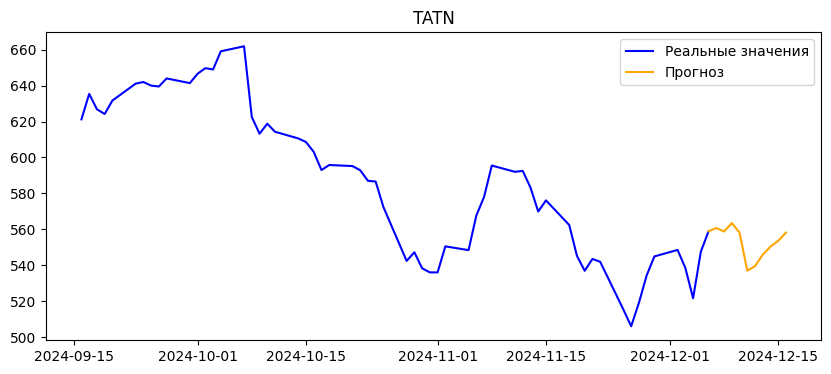

In [7]:
for col in ts_df:
    X = ts_df[[col]].tail(train_window)
    model = arima_estimator.fit(X.to_numpy())

    pred = model.predict(n_periods=test_window)
    pred_index = pd.date_range(start=X.index[-1] + pd.Timedelta(days=1), periods=test_window, freq="D")
    pred = pd.Series(pred)
    pred.index = pred_index

    pred = pd.concat([X[col].iloc[-1:], pred])

    combined = pd.concat([X[col], pred])

    plt.figure(figsize=(10, 4))

    plt.plot(X.index, X[col], label="Реальные значения", color="blue")
    plt.plot(pred.index, pred, label="Прогноз", color="orange")

    plt.title(col)
    plt.legend()
    plt.show()


Полученные ошибки будут взяты за основу при оценке качества других моделей.  
Однако стоит отметить несколько важных моментов:
- Прогнозные значения `ARIMA` зачастую сильнее отличаются от реальных значений на более удаленных шагах прогнозирования.  
    Поэтому, возможно, будет иметь смысл оценить не просто среднюю ошибку на прогнозе вперед на $10$ дней,  
    а рассмотреть различные горизонты этого прогнозирования.
- При построении более совершенных моделей, возможно, потребуется учитывать долгосрочную динамику, тогда от механизма  
    кросс-валидации в текущем его исполнении придется скорее всего отказаться. Предположительно, нужно будет  
    оставить те же самые тестовые временные периоды, но саму модель обучать на всех данных до конкретного тестового периода.